In [1]:
#Combined CSV files saved as dataall.csv
import os
import pandas as pd

# Directory containing hourly data CSV files
directory = "hourly_data"

# List to store data frames
data_frames = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        # Read CSV file and append to data_frames list
        data_frames.append(pd.read_csv(filepath))

# Concatenate all data frames into a single DataFrame
combined_data = pd.concat(data_frames, ignore_index=True)

# Save combined data to dataall.csv
combined_data.to_csv("dataall.csv", index=False)

print("Combined CSV files saved as dataall.csv")


Combined CSV files saved as dataall.csv


In [1]:
#create a csv file of time and average power

import pandas as pd

# Read data from dataall.csv
data = pd.read_csv("dataall.csv")

# Convert the 'Timestamp' column to datetime format with specified format
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y-%m-%d_%H-%M-%S')

# Extract date and hour from the timestamp
data['Date_Hour'] = data['Timestamp'].dt.strftime('%Y-%m-%d_%H')

# Calculate average power per hour
avg_power_per_hour = data.groupby('Date_Hour')['Power'].mean().reset_index()

# Rename columns for clarity
avg_power_per_hour.columns = ['Date_Hour', 'Avg_Power']

# Save to dataavg.csv
avg_power_per_hour.to_csv('dataavg.csv', index=False)


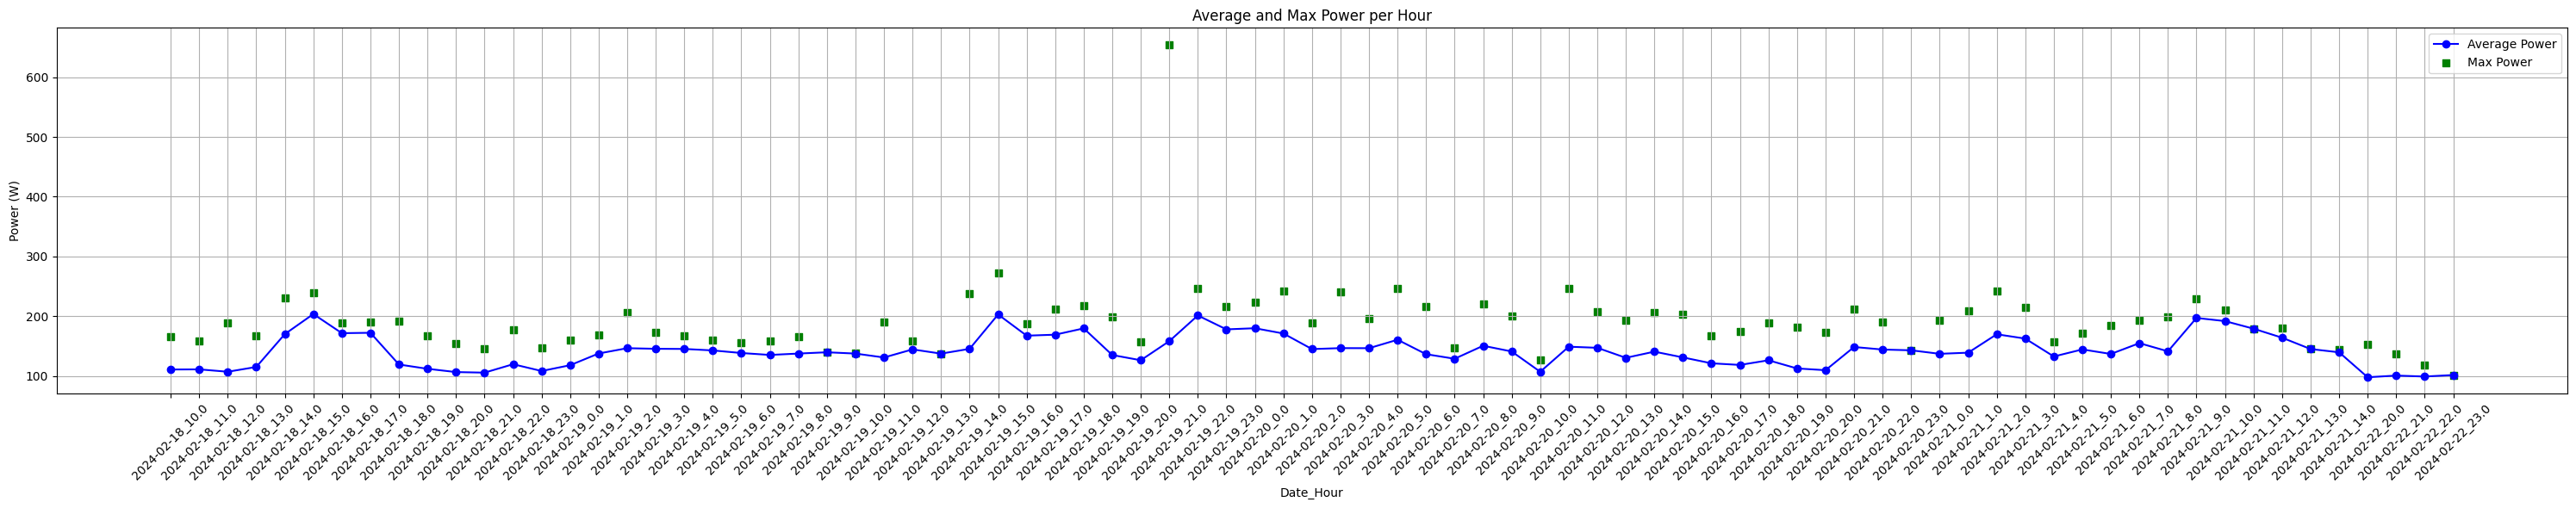

In [2]:
# Plot a graph of average and max power per hour

import pandas as pd
import matplotlib.pyplot as plt

# Read data from dataall.csv
data = pd.read_csv("dataall.csv")

# Convert the 'Timestamp' column to datetime format with specified format
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y-%m-%d_%H-%M-%S')

# Extract date and hour from the timestamp
data['Date'] = data['Timestamp'].dt.date
data['Hour'] = data['Timestamp'].dt.hour

# Calculate average and max power per hour
hourly_stats = data.groupby(['Date', 'Hour']).agg({'Power': ['mean', 'max']}).reset_index()
hourly_stats.columns = ['Date', 'Hour', 'Avg_Power', 'Max_Power']

# Create a combined string of date and hour for x-axis labels
hourly_stats['Date_Hour'] = hourly_stats['Date'].astype(str) + '_' + hourly_stats['Hour'].astype(str)

# Increase figure size
plt.figure(figsize=(30, 6))

# Plot average and max power per hour
plt.plot(hourly_stats['Date_Hour'], hourly_stats['Avg_Power'], marker='o', linestyle='-', color='blue', label='Average Power')
plt.scatter(hourly_stats['Date_Hour'], hourly_stats['Max_Power'], marker='s', color='green', label='Max Power')
plt.title('Average and Max Power per Hour')
plt.xlabel('Date_Hour')
plt.ylabel('Power (W)')
plt.xticks(rotation=45)
plt.legend()  # Add legend
plt.grid(True)
plt.tight_layout()
plt.show()


3/3 [==============================] - 1s 3ms/step


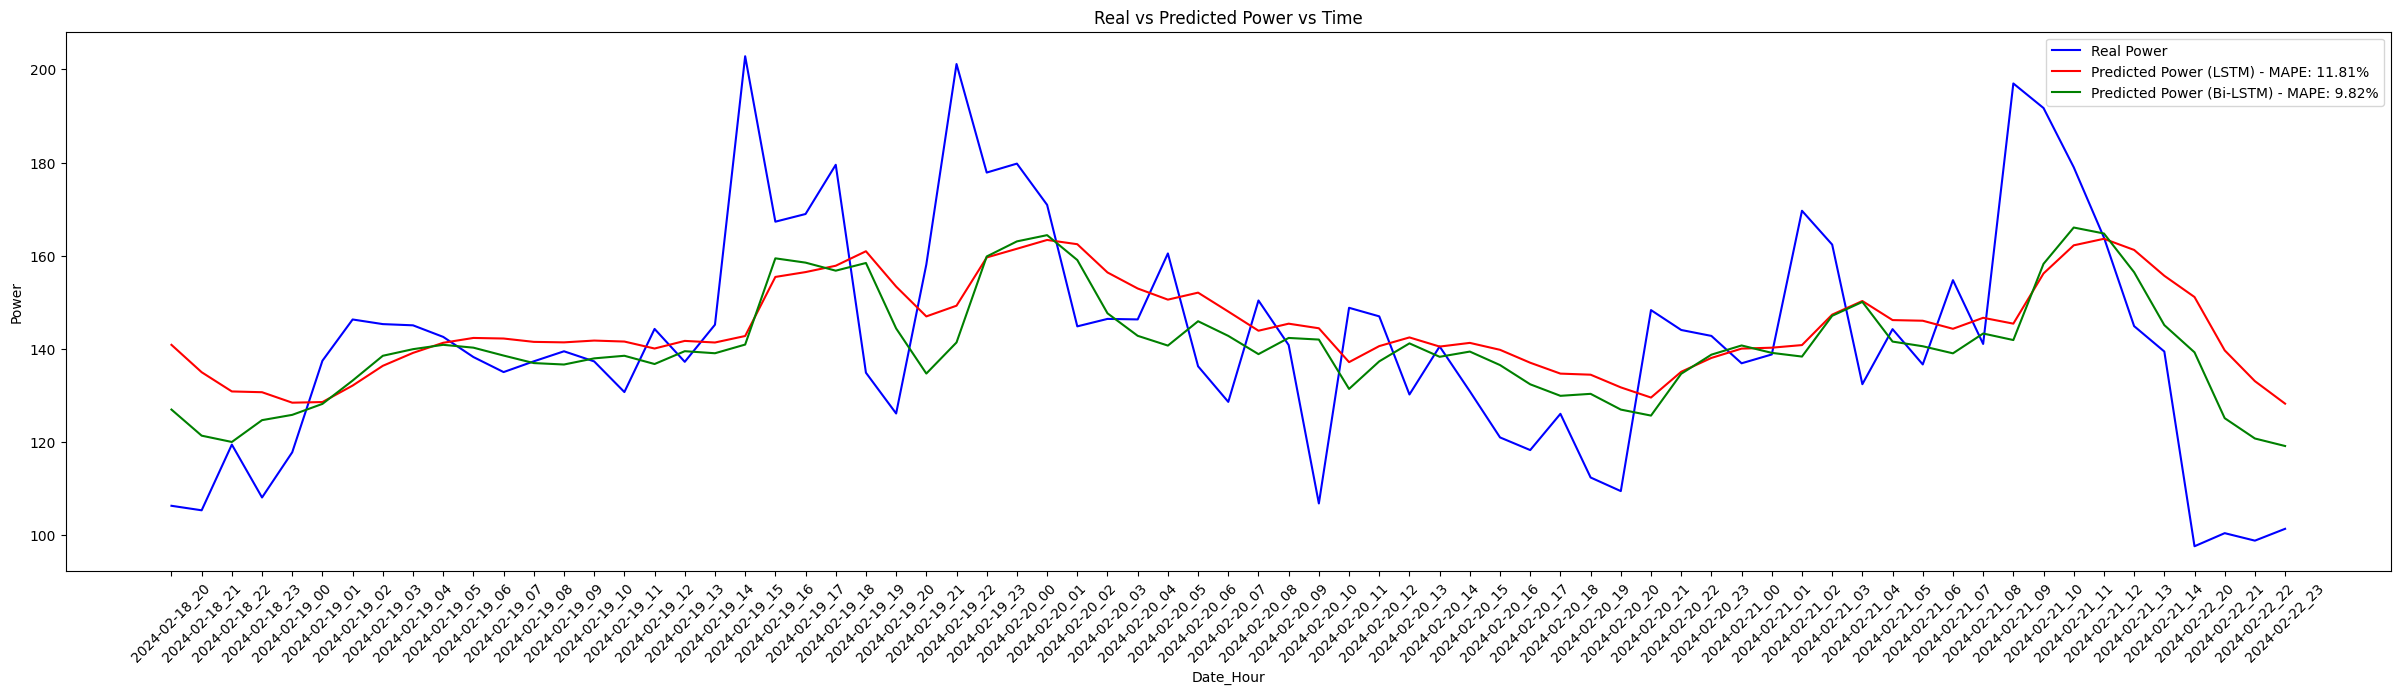

In [4]:
#train lstm and bi-lstm model and plot a graph

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf

# Load data from CSV file
data_df = pd.read_csv('dataavg.csv')

# Function to create time series data for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Function to create time series data for Bi-LSTM
def create_dataset_bilstm(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Train LSTM model
def train_model(X_train, y_train):
    model = Sequential([
        LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(units=1)
    ])
    model.compile(optimizer=tf.compat.v1.train.AdamOptimizer(), loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=70, batch_size=16, validation_split=0.1, verbose=0)
    return model, history

# Train Bi-LSTM model
def train_model_bilstm(X_train, y_train):
    model = Sequential([
        Bidirectional(LSTM(units=64), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(units=1)
    ])
    model.compile(optimizer=tf.compat.v1.train.AdamOptimizer(), loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=70, batch_size=16, validation_split=0.1, verbose=0)
    return model, history

# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_df['Avg_Power'].values.reshape(-1, 1))

# Create time series data for LSTM
X_train, y_train = create_dataset(scaled_data, scaled_data, time_steps=10)

# Train LSTM model
model, history = train_model(X_train, y_train)

# Create time series data for Bi-LSTM
X_train_bilstm, y_train_bilstm = create_dataset_bilstm(scaled_data, scaled_data, time_steps=10)

# Train Bi-LSTM model
model_bilstm, history_bilstm = train_model_bilstm(X_train_bilstm, y_train_bilstm)

# Predict using LSTM model
y_pred_lstm = model.predict(X_train)
y_pred_inv_lstm = scaler.inverse_transform(y_pred_lstm).reshape(-1)  # Reshape to 1D array

# Predict using Bi-LSTM model
y_pred_bilstm = model_bilstm.predict(X_train_bilstm)
y_pred_inv_bilstm = scaler.inverse_transform(y_pred_bilstm).reshape(-1)  # Reshape to 1D array

# Calculate MAPE for LSTM and Bi-LSTM
mape_lstm = calculate_mape(data_df['Avg_Power'].iloc[10:].values, y_pred_inv_lstm)
mape_bilstm = calculate_mape(data_df['Avg_Power'].iloc[10:].values, y_pred_inv_bilstm)

# Plot real vs predicted power for both predictions
plt.figure(figsize=(30, 7))
plt.plot(data_df['Date_Hour'].iloc[10:], data_df['Avg_Power'].iloc[10:], label='Real Power', color='blue')
plt.plot(data_df['Date_Hour'].iloc[10:], y_pred_inv_lstm, label=f'Predicted Power (LSTM) - MAPE: {mape_lstm:.2f}%', color='red')
plt.plot(data_df['Date_Hour'].iloc[10:], y_pred_inv_bilstm, label=f'Predicted Power (Bi-LSTM) - MAPE: {mape_bilstm:.2f}%', color='green')
plt.xlabel('Date_Hour')
plt.ylabel('Power')
plt.title('Real vs Predicted Power vs Time')
plt.legend()

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45)

plt.show()


3/3 [==============================] - 0s 4ms/step


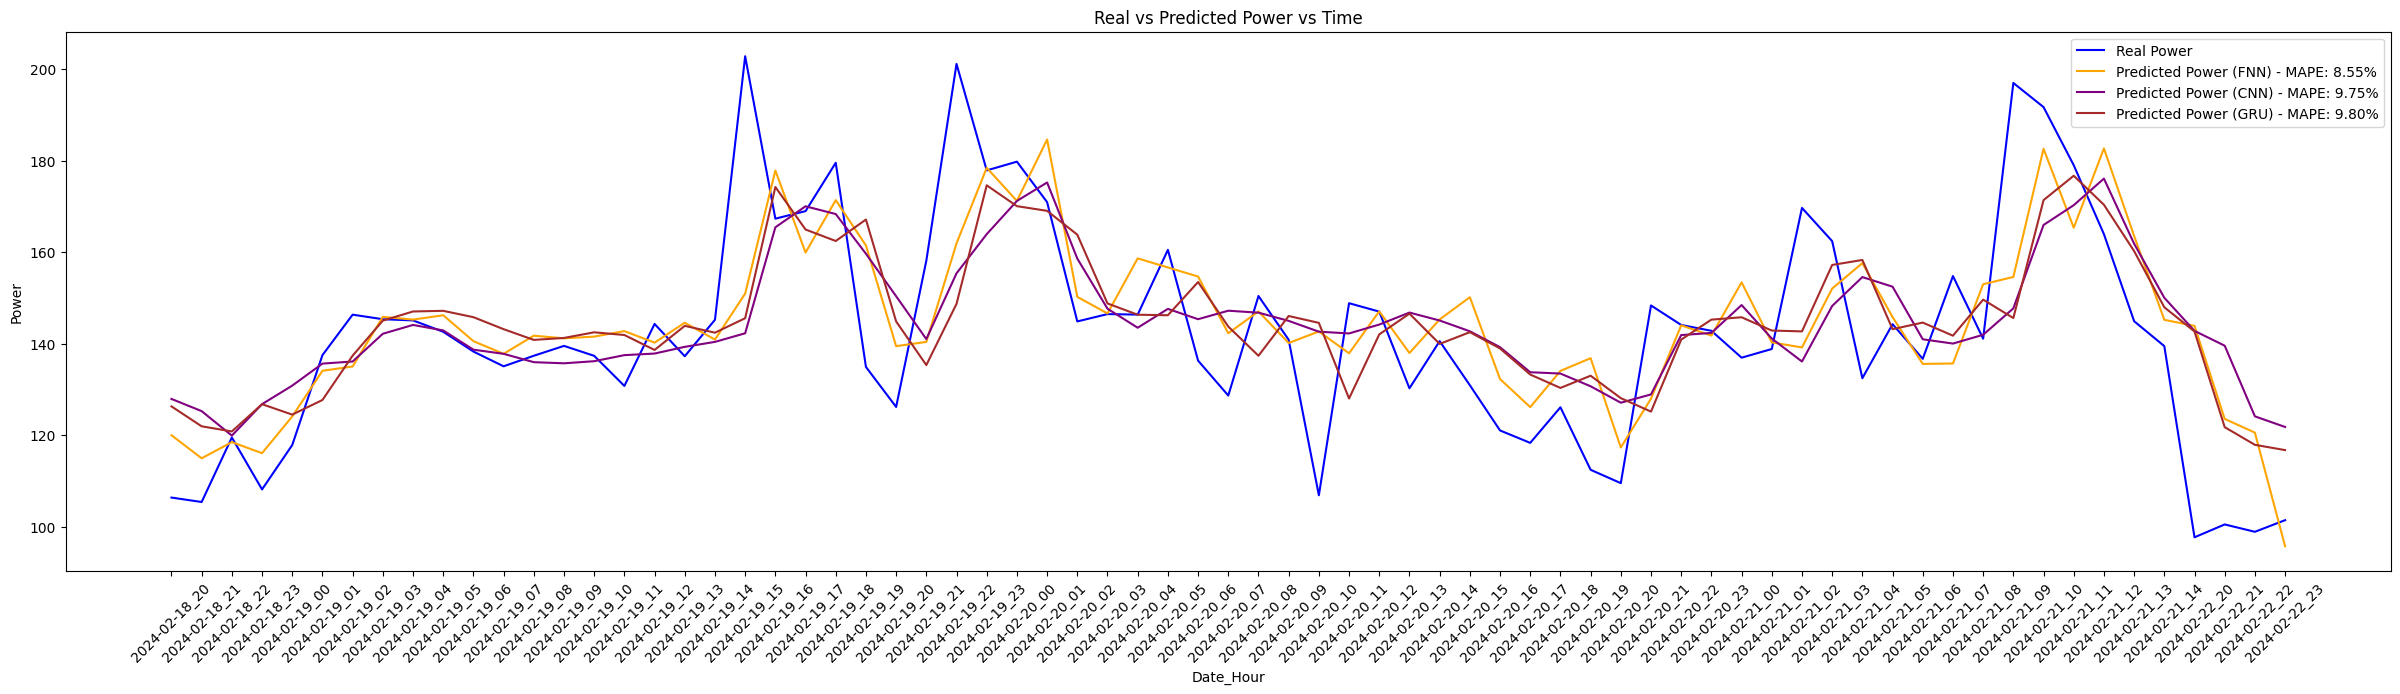

In [5]:
#train FNN,CNN and GRU model and plot a graph

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, SimpleRNN, GRU, Flatten, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf

# Load data from CSV file
data_df = pd.read_csv('dataavg.csv')

# Function to create time series data
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Train model
def train_model(model, X_train, y_train):
    model.compile(optimizer=tf.compat.v1.train.AdamOptimizer(), loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=70, batch_size=16, validation_split=0.1, verbose=0)
    return model, history

# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_df['Avg_Power'].values.reshape(-1, 1))

# Create time series data
X_train, y_train = create_dataset(scaled_data, scaled_data, time_steps=10)

# FNN model
model_fnn = Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

model_fnn, history_fnn = train_model(model_fnn, X_train, y_train)

# CNN model
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=1)
])

model_cnn, history_cnn = train_model(model_cnn, X_train, y_train)

# GRU model
model_gru = Sequential([
    GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])

model_gru, history_gru = train_model(model_gru, X_train, y_train)

# Predict using FNN model
y_pred_fnn = model_fnn.predict(X_train)
y_pred_inv_fnn = scaler.inverse_transform(y_pred_fnn).reshape(-1)  # Reshape to 1D array

# Predict using CNN model
y_pred_cnn = model_cnn.predict(X_train)
y_pred_inv_cnn = scaler.inverse_transform(y_pred_cnn).reshape(-1)  # Reshape to 1D array

# Predict using GRU model
y_pred_gru = model_gru.predict(X_train)
y_pred_inv_gru = scaler.inverse_transform(y_pred_gru).reshape(-1)  # Reshape to 1D array

# Calculate MAPE for FNN, CNN, and GRU models
mape_fnn = calculate_mape(data_df['Avg_Power'].iloc[10:].values, y_pred_inv_fnn)
mape_cnn = calculate_mape(data_df['Avg_Power'].iloc[10:].values, y_pred_inv_cnn)
mape_gru = calculate_mape(data_df['Avg_Power'].iloc[10:].values, y_pred_inv_gru)

# Plot real vs predicted power for all models
plt.figure(figsize=(30, 7))
plt.plot(data_df['Date_Hour'].iloc[10:], data_df['Avg_Power'].iloc[10:], label='Real Power', color='blue')
plt.plot(data_df['Date_Hour'].iloc[10:], y_pred_inv_fnn, label=f'Predicted Power (FNN) - MAPE: {mape_fnn:.2f}%', color='orange')
plt.plot(data_df['Date_Hour'].iloc[10:], y_pred_inv_cnn, label=f'Predicted Power (CNN) - MAPE: {mape_cnn:.2f}%', color='purple')
plt.plot(data_df['Date_Hour'].iloc[10:], y_pred_inv_gru, label=f'Predicted Power (GRU) - MAPE: {mape_gru:.2f}%', color='brown')
plt.xlabel('Date_Hour')
plt.ylabel('Power')
plt.title('Real vs Predicted Power vs Time')
plt.legend()

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45)

plt.show()


In [6]:
#Predicted power output for the next hour
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Flatten, Conv1D, MaxPooling1D, GRU
import matplotlib.pyplot as plt
import tensorflow as tf

# Load data from CSV file
data_df = pd.read_csv('dataavg.csv')

# Function to create time series data
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Train model
def train_model(model, X_train, y_train):
    model.compile(optimizer=tf.compat.v1.train.AdamOptimizer(), loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=70, batch_size=16, validation_split=0.1, verbose=0)
    return model, history

# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_df['Avg_Power'].values.reshape(-1, 1))

# Create time series data
X_train, y_train = create_dataset(scaled_data, scaled_data, time_steps=10)

# LSTM model
model_lstm = Sequential([
    LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])

model_lstm, history_lstm = train_model(model_lstm, X_train, y_train)

# Bi-LSTM model
model_bilstm = Sequential([
    Bidirectional(LSTM(units=64), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])

model_bilstm, history_bilstm = train_model(model_bilstm, X_train, y_train)

# FNN model
model_fnn = Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

model_fnn, history_fnn = train_model(model_fnn, X_train, y_train)

# CNN model
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=1)
])

model_cnn, history_cnn = train_model(model_cnn, X_train, y_train)

# GRU model
model_gru = Sequential([
    GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])

model_gru, history_gru = train_model(model_gru, X_train, y_train)

# Select the last 10 data points from the dataset
last_data_points = scaled_data[-10:]

# Reshape the data to match the input shape of the models
last_data_points = last_data_points.reshape((1, 10, 1))

# Predict the power output for the next hour using each model
next_hour_pred_lstm = model_lstm.predict(last_data_points)
next_hour_pred_bilstm = model_bilstm.predict(last_data_points)
next_hour_pred_fnn = model_fnn.predict(last_data_points)
next_hour_pred_cnn = model_cnn.predict(last_data_points)
next_hour_pred_gru = model_gru.predict(last_data_points)

# Invert the scaling to get the actual power output values
next_hour_pred_lstm = scaler.inverse_transform(next_hour_pred_lstm)[0][0]
next_hour_pred_bilstm = scaler.inverse_transform(next_hour_pred_bilstm)[0][0]
next_hour_pred_fnn = scaler.inverse_transform(next_hour_pred_fnn)[0][0]
next_hour_pred_cnn = scaler.inverse_transform(next_hour_pred_cnn)[0][0]
next_hour_pred_gru = scaler.inverse_transform(next_hour_pred_gru)[0][0]

print("Predicted power output for the next hour (LSTM):", next_hour_pred_lstm)
print("Predicted power output for the next hour (Bi-LSTM):", next_hour_pred_bilstm)
print("Predicted power output for the next hour (FNN):", next_hour_pred_fnn)
print("Predicted power output for the next hour (CNN):", next_hour_pred_cnn)
print("Predicted power output for the next hour (GRU):", next_hour_pred_gru)


1/1 [==============================] - 0s 380ms/step
Predicted power output for the next hour (LSTM): 123.796486
Predicted power output for the next hour (Bi-LSTM): 122.26367
Predicted power output for the next hour (FNN): 124.06779
Predicted power output for the next hour (CNN): 117.027084
Predicted power output for the next hour (GRU): 119.26679
